# Import Libraries

In [1]:
import pandas as pd
import numpy as np

# sklearn for utilization
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import recall_score, precision_score, fbeta_score
from sklearn.model_selection import StratifiedKFold

# modelling for ensemble method
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

# visualization purpose
import matplotlib.pyplot as plt

# utils
import pickle
import random

# import our ensemble stacking model here
from models.model_ensembles import EnsembleStacking

In [2]:
# for reproducecibility
random_state = 60251014
random.seed(random_state)

# Load Data After Preprocessing
***
Load data Breast Cancer Diagnosis and Breast Cancer Prognosis after cleaned and preprocessed

In [3]:
breast_cancer_preprocessed = pickle.load(open('../dataset/preprocessed_breast_cancer_data.pkl', 'rb'))

# diagnosis breast cancer dataset
diagnosis_X_train_original = breast_cancer_preprocessed['diagnosis']['original']['X_train']
diagnosis_X_train_downsampling = breast_cancer_preprocessed['diagnosis']['downsampling']['X_train']
diagnosis_X_train_upsampling = breast_cancer_preprocessed['diagnosis']['upsampling']['X_train']

diagnosis_y_train_original = breast_cancer_preprocessed['diagnosis']['original']['y_train']
diagnosis_y_train_downsampling = breast_cancer_preprocessed['diagnosis']['downsampling']['y_train']
diagnosis_y_train_upsampling = breast_cancer_preprocessed['diagnosis']['upsampling']['y_train']

diagnosis_X_test_original = breast_cancer_preprocessed['diagnosis']['original']['X_test']
diagnosis_y_test_original = breast_cancer_preprocessed['diagnosis']['original']['y_test']



# prognosis breast cancer dataset
prognosis_X_train_original = breast_cancer_preprocessed['prognosis']['original']['X_train']
prognosis_X_train_downsampling = breast_cancer_preprocessed['prognosis']['downsampling']['X_train']
prognosis_X_train_upsampling = breast_cancer_preprocessed['prognosis']['upsampling']['X_train']

prognosis_y_train_original = breast_cancer_preprocessed['prognosis']['original']['y_train']
prognosis_y_train_downsampling = breast_cancer_preprocessed['prognosis']['downsampling']['y_train']
prognosis_y_train_upsampling = breast_cancer_preprocessed['prognosis']['upsampling']['y_train']

prognosis_X_test_original = breast_cancer_preprocessed['prognosis']['original']['X_test']
prognosis_y_test_original = breast_cancer_preprocessed['prognosis']['original']['y_test']

# Defining Global Variables

In [4]:
kfold = StratifiedKFold(n_splits=5, random_state=45, shuffle=True)

# global variables for MLP
hidden_layer_sizes=(100,20)
max_iter=100
batch_size=64 
verbose=1
n_iter_no_change=20

# Defining Global Functions

In [5]:
def create_new_input_features(ensemble_classifiers, X, y):
    all_predicted_results = dict()
    list_of_majority_voting_each_models = list()
    list_of_models = list()

    for model_name, models in ensemble_classifiers.items():
        print("\t\t\t", model_name.upper())

        # voting scenario for new data input prepration for ANN model
        if len(models)!=0:
            all_predicted_results[model_name] = dict()
            for sub_model_name, dict_models in models.items():
                all_predicted_results[model_name][sub_model_name] = dict_models['train'].predict(X)

            # make dataframe for 5 model prediction results on X and get the mode label for that 5 prediction
            model_df_voting = pd.DataFrame(all_predicted_results[model_name]).mode(axis=1)[0]
            list_of_models.append('majority_vote_from_'+model_name)
            list_of_majority_voting_each_models.append(model_df_voting)
            
    new_input_features = pd.concat(list_of_majority_voting_each_models, axis=1)
    new_input_features.columns = list_of_models
    new_input_features['ground_truth'] = y.copy()
            
    return new_input_features

In [6]:
def print_model_experiment_results(name_of_scenario, y_test, y_pred):
    print('\t\t' + '='*30)
    print('\t\tHASIl UJI COBA {}'.format(name_of_scenario.upper()))
    print('\t\t' + '='*30)
    print("\tAkurasi Score: ", accuracy_score(y_test, y_pred))
    print("\tMacro Recall Score: ", recall_score(y_test, y_pred, average='macro'))
    print("\tMacro Precision Score: ", precision_score(y_test, y_pred, average='macro'))
    print("\tMacro F1-score Score: ", fbeta_score(y_test, y_pred, beta=1, average='macro'))
    print("\tMacro F2-score Score: ", fbeta_score(y_test, y_pred, beta=2, average='macro'))
    print("\tMacro F0.5-score Score: ", fbeta_score(y_test, y_pred, beta=0.5, average='macro'))
    
    print()
    print()
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    plt.figure(figsize=(14,8))
    disp.plot()
    plt.show()

# <Do Your Hyperparameter Optimization Techniques Here (Grid Search or Genetic Algorithm!>

***
Find the best optimal hyperparameter from each model (SVM, DT, LR and also hyperparameter in ANN) and then build your model using the those best hyperparameter combination. <br>
You can customize Ensemble Classifiers codes in this folder or path: "models/model_ensembles.py"

# Modelling Ensemble Classifiers for Diagnosis Breast Cancer Dataset

## Without Data Sampling Method (Original)

### Create Stacking ML Ensemble using 5-fold cross-validation

In [7]:
ensemble_classifiers_diagnosis_original = EnsembleStacking(
    diagnosis_X_train_original, 
    diagnosis_y_train_original, 
    diagnosis_X_test_original, 
    diagnosis_y_test_original, 
    kfold).train_ensemble()

In [8]:
# create dataframe for easy understanding from ensemble classifiers stacking results
ensemble_classifiers_results_diagnosis_original = list()
for model in ensemble_classifiers_diagnosis_original.keys():
    ensemble_classifiers_results_diagnosis_original.append(pd.DataFrame(ensemble_classifiers_diagnosis_original[model]).transpose().sort_values(by=['testing'], ascending=False))

# concat all dataframe results
ensemble_classifiers_results_diagnosis_original = pd.concat(ensemble_classifiers_results_diagnosis_original, axis=0)
ensemble_classifiers_results_diagnosis_original

,train,training,validation,testing
model-5,SVC(),0.950549,0.978022,0.964912
model-1,SVC(),0.964286,0.901099,0.95614
model-2,SVC(),0.947802,0.912088,0.95614
model-3,SVC(),0.947802,0.956044,0.95614
model-4,SVC(),0.958791,0.945055,0.95614
model-1,LogisticRegression(solver='newton-cg'),0.945055,0.912088,0.95614
model-2,LogisticRegression(solver='newton-cg'),0.945055,0.912088,0.95614
model-3,LogisticRegression(solver='newton-cg'),0.934066,0.945055,0.95614
model-4,LogisticRegression(solver='newton-cg'),0.942308,0.934066,0.95614
model-5,LogisticRegression(solver='newton-cg'),0.928571,0.978022,0.95614


### Create New Input Training from stacking ensemble ML

In [9]:
new_input_training_features_diagnosis_original = create_new_input_features(
    ensemble_classifiers_diagnosis_original, 
    diagnosis_X_train_original,
    diagnosis_y_train_original
)

			 SVM
			 LOGREG
			 NAIVE_BAYES
			 DECISION_TREE


In [10]:
new_input_training_features_diagnosis_original.head()

,majority_vote_from_svm,majority_vote_from_logreg,majority_vote_from_naive_bayes,majority_vote_from_decision_tree,ground_truth
0,0,0,0,0,0
1,1,1,0,1,1
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0


### Feed New Input Features into ANN Model

In [11]:
# split X and y from new_input_features before feeding to ANN
new_X_train = new_input_training_features_diagnosis_original.drop(['ground_truth'],axis=1)
new_y_train = new_input_training_features_diagnosis_original['ground_truth']

# feed new X and new y into ANN
ann_model_diagnosis_original = MLPClassifier(
    hidden_layer_sizes=hidden_layer_sizes,
    max_iter=max_iter, 
    batch_size=batch_size, 
    verbose=verbose,
    n_iter_no_change=n_iter_no_change
)
ann_model_diagnosis_original.fit(new_X_train, new_y_train)
predicted_ann_train_diagnosis_original = ann_model_diagnosis_original.predict(new_X_train)
predicted_ann_train_diagnosis_original = ann_model_diagnosis_original.predict(new_X_train)


print()
print()
print("Final Accuracy Score [Mls Ensembles + ANN] on Training Diagnostic Dataset (Original) = ", accuracy_score(new_y_train, predicted_ann_train_diagnosis_original))

Iteration 1, loss = 0.67903142
Iteration 2, loss = 0.61928541
Iteration 3, loss = 0.56436219
Iteration 4, loss = 0.50952293
Iteration 5, loss = 0.46015014
Iteration 6, loss = 0.41087924
Iteration 7, loss = 0.36298899
Iteration 8, loss = 0.31526495
Iteration 9, loss = 0.26888373
Iteration 10, loss = 0.22654516
Iteration 11, loss = 0.18897883
Iteration 12, loss = 0.15695702
Iteration 13, loss = 0.13005712
Iteration 14, loss = 0.10848867
Iteration 15, loss = 0.09079062
Iteration 16, loss = 0.07675873
Iteration 17, loss = 0.06480663
Iteration 18, loss = 0.05548915
Iteration 19, loss = 0.04738684
Iteration 20, loss = 0.04057369
Iteration 21, loss = 0.03541403
Iteration 22, loss = 0.03081651
Iteration 23, loss = 0.02693628
Iteration 24, loss = 0.02363617
Iteration 25, loss = 0.02103554
Iteration 26, loss = 0.01868242
Iteration 27, loss = 0.01662841
Iteration 28, loss = 0.01478070
Iteration 29, loss = 0.01329506
Iteration 30, loss = 0.01194437
Iteration 31, loss = 0.01083548
Iteration 32, los

## With Data Sampling Method (Upsampling)

### Create Stacking ML Ensemble using 5-fold cross-validation

In [12]:
ensemble_classifiers_diagnosis_upsampling = EnsembleStacking(
    diagnosis_X_train_upsampling, 
    diagnosis_y_train_upsampling, 
    diagnosis_X_test_original, 
    diagnosis_y_test_original, 
    kfold).train_ensemble()

In [13]:
# create dataframe for easy understanding from ensemble classifiers stacking results
ensemble_classifiers_results_diagnosis_upsampling = list()
for model in ensemble_classifiers_diagnosis_upsampling.keys():
    ensemble_classifiers_results_diagnosis_upsampling.append(pd.DataFrame(ensemble_classifiers_diagnosis_upsampling[model]).transpose().sort_values(by=['testing'], ascending=False))

# concat all dataframe results
ensemble_classifiers_results_diagnosis_upsampling = pd.concat(ensemble_classifiers_results_diagnosis_upsampling, axis=0)
ensemble_classifiers_results_diagnosis_upsampling

,train,training,validation,testing
model-1,SVC(),0.958425,0.930435,0.973684
model-3,SVC(),0.943231,0.938596,0.964912
model-5,SVC(),0.958515,0.912281,0.964912
model-2,SVC(),0.95186,0.965217,0.95614
model-4,SVC(),0.949782,0.964912,0.947368
model-1,LogisticRegression(solver='newton-cg'),0.932166,0.947826,0.964912
model-2,LogisticRegression(solver='newton-cg'),0.934354,0.930435,0.95614
model-3,LogisticRegression(solver='newton-cg'),0.936681,0.929825,0.95614
model-4,LogisticRegression(solver='newton-cg'),0.934498,0.947368,0.95614
model-5,LogisticRegression(solver='newton-cg'),0.941048,0.912281,0.95614


### Create New Input Training from stacking ensemble ML

In [14]:
new_input_training_features_diagnosis_upsampling = create_new_input_features(
    ensemble_classifiers_diagnosis_upsampling, 
    diagnosis_X_train_upsampling,
    diagnosis_y_train_upsampling
)

			 SVM
			 LOGREG
			 NAIVE_BAYES
			 DECISION_TREE


In [15]:
new_input_training_features_diagnosis_upsampling.head()

,majority_vote_from_svm,majority_vote_from_logreg,majority_vote_from_naive_bayes,majority_vote_from_decision_tree,ground_truth
0,1,1,1,1,1
1,0,0,0,0,0
2,1,1,1,1,1
3,0,0,0,0,0
4,1,1,1,1,1


### Feed New Input Features into ANN Model

In [16]:
# split X and y from new_input_features before feeding to ANN
new_X_train = new_input_training_features_diagnosis_upsampling.drop(['ground_truth'],axis=1)
new_y_train = new_input_training_features_diagnosis_upsampling['ground_truth']

# feed new X and new y into ANN
ann_model_diagnosis_upsampling = MLPClassifier(
    hidden_layer_sizes=hidden_layer_sizes,
    max_iter=max_iter, 
    batch_size=batch_size, 
    verbose=verbose,
    n_iter_no_change=n_iter_no_change
)
ann_model_diagnosis_upsampling.fit(new_X_train, new_y_train)
predicted_ann_train_diagnosis_upsampling = ann_model_diagnosis_upsampling.predict(new_X_train)
predicted_ann_train_diagnosis_upsampling = ann_model_diagnosis_upsampling.predict(new_X_train)


print()
print()
print("Final Accuracy Score [Mls Ensembles + ANN] on Training Diagnostic Dataset (Downsampling) = ", accuracy_score(new_y_train, predicted_ann_train_diagnosis_upsampling))

Iteration 1, loss = 0.71281169
Iteration 2, loss = 0.62071326
Iteration 3, loss = 0.54456314
Iteration 4, loss = 0.47556891
Iteration 5, loss = 0.41266980
Iteration 6, loss = 0.35127948
Iteration 7, loss = 0.29275279
Iteration 8, loss = 0.24240994
Iteration 9, loss = 0.19851839
Iteration 10, loss = 0.16207080
Iteration 11, loss = 0.13156798
Iteration 12, loss = 0.10519887
Iteration 13, loss = 0.08357784
Iteration 14, loss = 0.06570802
Iteration 15, loss = 0.05213368
Iteration 16, loss = 0.04180255
Iteration 17, loss = 0.03349054
Iteration 18, loss = 0.02752331
Iteration 19, loss = 0.02262474
Iteration 20, loss = 0.01913637
Iteration 21, loss = 0.01623871
Iteration 22, loss = 0.01393487
Iteration 23, loss = 0.01206733
Iteration 24, loss = 0.01062098
Iteration 25, loss = 0.00939702
Iteration 26, loss = 0.00835547
Iteration 27, loss = 0.00748322
Iteration 28, loss = 0.00674916
Iteration 29, loss = 0.00614568
Iteration 30, loss = 0.00558108
Iteration 31, loss = 0.00511265
Iteration 32, los

## With Data Sampling Method (Downsampling)

### Create Stacking ML Ensemble using 5-fold cross-validation

In [17]:
ensemble_classifiers_diagnosis_downsampling = EnsembleStacking(
    diagnosis_X_train_downsampling, 
    diagnosis_y_train_downsampling, 
    diagnosis_X_test_original, 
    diagnosis_y_test_original, 
    kfold).train_ensemble()

In [18]:
# create dataframe for easy understanding from ensemble classifiers stacking results
ensemble_classifiers_results_diagnosis_downsampling = list()
for model in ensemble_classifiers_diagnosis_downsampling.keys():
    ensemble_classifiers_results_diagnosis_downsampling.append(pd.DataFrame(ensemble_classifiers_diagnosis_downsampling[model]).transpose().sort_values(by=['testing'], ascending=False))

# concat all dataframe results
ensemble_classifiers_results_diagnosis_downsampling = pd.concat(ensemble_classifiers_results_diagnosis_downsampling, axis=0)
ensemble_classifiers_results_diagnosis_downsampling

,train,training,validation,testing
model-1,SVC(),0.933333,0.926471,0.982456
model-2,SVC(),0.948148,0.897059,0.982456
model-3,SVC(),0.937037,0.955882,0.95614
model-4,SVC(),0.933579,0.895522,0.95614
model-5,SVC(),0.944649,0.895522,0.95614
model-2,LogisticRegression(solver='newton-cg'),0.922222,0.941176,0.964912
model-1,LogisticRegression(solver='newton-cg'),0.925926,0.926471,0.95614
model-3,LogisticRegression(solver='newton-cg'),0.911111,0.941176,0.95614
model-4,LogisticRegression(solver='newton-cg'),0.926199,0.910448,0.95614
model-5,LogisticRegression(solver='newton-cg'),0.926199,0.880597,0.95614


### Create New Input Training from stacking ensemble ML

In [19]:
new_input_training_features_diagnosis_downsampling = create_new_input_features(
    ensemble_classifiers_diagnosis_downsampling, 
    diagnosis_X_train_downsampling,
    diagnosis_y_train_downsampling
)

			 SVM
			 LOGREG
			 NAIVE_BAYES
			 DECISION_TREE


In [20]:
new_input_training_features_diagnosis_downsampling.head()

,majority_vote_from_svm,majority_vote_from_logreg,majority_vote_from_naive_bayes,majority_vote_from_decision_tree,ground_truth
0,0,0,0,0,0
1,1,1,0,1,1
2,1,1,1,1,1
3,1,1,1,1,1
4,1,1,1,1,1


### Feed New Input Features into ANN Model

In [21]:
# split X and y from new_input_features before feeding to ANN
new_X_train = new_input_training_features_diagnosis_downsampling.drop(['ground_truth'],axis=1)
new_y_train = new_input_training_features_diagnosis_downsampling['ground_truth']

# feed new X and new y into ANN
ann_model_diagnosis_downsampling = MLPClassifier(
    hidden_layer_sizes=hidden_layer_sizes,
    max_iter=max_iter, 
    batch_size=batch_size, 
    verbose=verbose,
    n_iter_no_change=n_iter_no_change
)
ann_model_diagnosis_downsampling.fit(new_X_train, new_y_train)
predicted_ann_train_diagnosis_downsampling = ann_model_diagnosis_downsampling.predict(new_X_train)
predicted_ann_train_diagnosis_downsampling = ann_model_diagnosis_downsampling.predict(new_X_train)


print()
print()
print("Final Accuracy Score [Mls Ensembles + ANN] on Training Diagnostic Dataset (Downsampling) = ", accuracy_score(new_y_train, predicted_ann_train_diagnosis_downsampling))

Iteration 1, loss = 0.70814275
Iteration 2, loss = 0.64628327
Iteration 3, loss = 0.59172434
Iteration 4, loss = 0.54406974
Iteration 5, loss = 0.50065050
Iteration 6, loss = 0.45949162
Iteration 7, loss = 0.41909247
Iteration 8, loss = 0.38110474
Iteration 9, loss = 0.34617505
Iteration 10, loss = 0.31550233
Iteration 11, loss = 0.28637537
Iteration 12, loss = 0.25545698
Iteration 13, loss = 0.22183076
Iteration 14, loss = 0.18941044
Iteration 15, loss = 0.16012789
Iteration 16, loss = 0.13481822
Iteration 17, loss = 0.11266194
Iteration 18, loss = 0.09458834
Iteration 19, loss = 0.07907176
Iteration 20, loss = 0.06648384
Iteration 21, loss = 0.05670509
Iteration 22, loss = 0.04821365
Iteration 23, loss = 0.04143504
Iteration 24, loss = 0.03599657
Iteration 25, loss = 0.03153831
Iteration 26, loss = 0.02776028
Iteration 27, loss = 0.02454236
Iteration 28, loss = 0.02191617
Iteration 29, loss = 0.01970497
Iteration 30, loss = 0.01775906
Iteration 31, loss = 0.01611250
Iteration 32, los

# Testing Results

## Without Data Sampling (Original)

### Create New Input Features from stacking ensemble ML before ANN process for preparing testing data new input features

In [22]:
new_input_testing_features_diagnosis_original = create_new_input_features(
    ensemble_classifiers_diagnosis_original, 
    diagnosis_X_test_original,
    diagnosis_y_test_original
)

			 SVM
			 LOGREG
			 NAIVE_BAYES
			 DECISION_TREE


### Feed new testing input features into ANN pre-trained model

		HASIl UJI COBA HASIL PENGUJIAN DATA TESTING DIAGNOSIS BREAST CANCER (ORIGINAL)
	Akurasi Score:  0.9473684210526315
	Macro Recall Score:  0.9394038650507697
	Macro Precision Score:  0.9482124958235884
	Macro F1-score Score:  0.9434523809523809
	Macro F2-score Score:  0.9409397561841638
	Macro F0.5-score Score:  0.9462211043238712


              precision    recall  f1-score   support

           0       0.95      0.97      0.96        71
           1       0.95      0.91      0.93        43

    accuracy                           0.95       114
   macro avg       0.95      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114



<Figure size 1008x576 with 0 Axes>

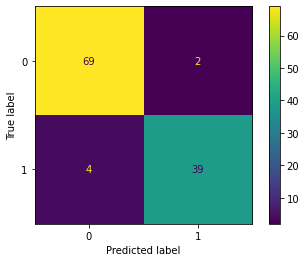

In [23]:
# split X and y from new_input_features before feeding to ANN
new_X_test = new_input_testing_features_diagnosis_original.drop(['ground_truth'],axis=1)
new_y_test = new_input_testing_features_diagnosis_original['ground_truth']

# predict new X test using pre-trained ANN before
predicted_test_original = ann_model_diagnosis_original.predict(new_X_test)

# print testing results
print_model_experiment_results('Hasil Pengujian Data Testing Diagnosis Breast Cancer (Original)', new_y_test, predicted_test_original)

## With Data Sampling Method (Upsampling)

### Create New Input Features from stacking ensemble ML before ANN process for preparing testing data new input features

In [24]:
new_input_testing_features_diagnosis_upsampling = create_new_input_features(
    ensemble_classifiers_diagnosis_upsampling, 
    diagnosis_X_test_original,
    diagnosis_y_test_original
)

			 SVM
			 LOGREG
			 NAIVE_BAYES
			 DECISION_TREE


### Feed new testing input features into ANN pre-trained model

		HASIl UJI COBA HASIL PENGUJIAN DATA TESTING DIAGNOSIS BREAST CANCER (UPSAMPLING)
	Akurasi Score:  0.9298245614035088
	Macro Recall Score:  0.9299050114641336
	Macro Precision Score:  0.9227053140096618
	Macro F1-score Score:  0.925974025974026
	Macro F2-score Score:  0.9282515894048382
	Macro F0.5-score Score:  0.9239348160401133


              precision    recall  f1-score   support

           0       0.96      0.93      0.94        71
           1       0.89      0.93      0.91        43

    accuracy                           0.93       114
   macro avg       0.92      0.93      0.93       114
weighted avg       0.93      0.93      0.93       114



<Figure size 1008x576 with 0 Axes>

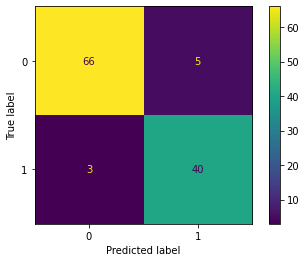

In [25]:
# split X and y from new_input_features before feeding to ANN
new_X_test = new_input_testing_features_diagnosis_upsampling.drop(['ground_truth'],axis=1)
new_y_test = new_input_testing_features_diagnosis_upsampling['ground_truth']

# predict new X test using pre-trained ANN before
predicted_test_upsampling = ann_model_diagnosis_upsampling.predict(new_X_test)

# print testing results
print_model_experiment_results('Hasil Pengujian Data Testing Diagnosis Breast Cancer (Upsampling)', new_y_test, predicted_test_upsampling)

## With Data Sampling Method (Downsampling)

### Create New Input Features from stacking ensemble ML before ANN process for preparing testing data new input features

In [26]:
new_input_testing_features_diagnosis_downsampling = create_new_input_features(
    ensemble_classifiers_diagnosis_downsampling, 
    diagnosis_X_test_original,
    diagnosis_y_test_original
)

			 SVM
			 LOGREG
			 NAIVE_BAYES
			 DECISION_TREE


### Feed new testing input features into ANN pre-trained model

		HASIl UJI COBA HASIL PENGUJIAN DATA TESTING DIAGNOSIS BREAST CANCER (DOWNSAMPLING)
	Akurasi Score:  0.9385964912280702
	Macro Recall Score:  0.9415329184408778
	Macro Precision Score:  0.9309462915601023
	Macro F1-score Score:  0.9354943011882629
	Macro F2-score Score:  0.9389334862385321
	Macro F0.5-score Score:  0.9325914129024799


              precision    recall  f1-score   support

           0       0.97      0.93      0.95        71
           1       0.89      0.95      0.92        43

    accuracy                           0.94       114
   macro avg       0.93      0.94      0.94       114
weighted avg       0.94      0.94      0.94       114



<Figure size 1008x576 with 0 Axes>

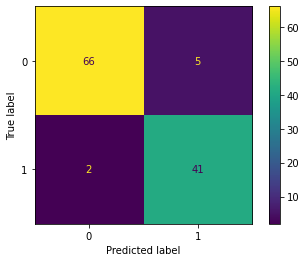

In [27]:
# split X and y from new_input_features before feeding to ANN
new_X_test = new_input_testing_features_diagnosis_downsampling.drop(['ground_truth'],axis=1)
new_y_test = new_input_testing_features_diagnosis_downsampling['ground_truth']

# predict new X test using pre-trained ANN before
predicted_test_downsampling = ann_model_diagnosis_downsampling.predict(new_X_test)

# print testing results
print_model_experiment_results('Hasil Pengujian Data Testing Diagnosis Breast Cancer (Downsampling)', new_y_test, predicted_test_downsampling)